# 사물 이미지 분류 경진대회

## 데이터 불러오기

`-` 구글 코랩에서 코딩함
 
`-` 업데이트 속도가 조금 느리다

In [63]:
import os
import pandas as pd
import warnings
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결
warnings.filterwarnings('ignore')

In [25]:
cd '/content/drive/My Drive/Colab Notebooks/CIFAR10'

/content/drive/My Drive/Colab Notebooks/CIFAR10


In [1]:
#!unzip -o 'data.zip' ## 현재 디렉토리에 존재하는 data.zip이라는 zip파일을 지정한 경로에 압축해제

In [27]:
## 데이터를 불러올 함수를 정의
def load_CIFAR10(path, train=True):
    '''
    If train then
        path -> folder1, folder2, ..., folder10
        folder1 -> img1, img2, ..., img5000
        ...
        folder10 -> img1, img2, ..., img5000
        
    If test then
        path -> img1, img2, ..., img5000
    '''
    from tqdm import tqdm
    path = path ## 이미지 파일들이 담겨있는 폴더들이 담겨있는 파일 경로
    images = [] ## 이미지 리스트
    labels = [] ## 라벨 리스트
    
    ## train
    if train:
        for foldername in tqdm(os.listdir(path)): ## 이미지 파일들이 담겨있는 폴더 이름(=라벨)
            img_path = path + foldername + '/'
            for img in os.listdir(img_path):  ## 폴더에 담겨있는 이미지들
                an_img = Image.open(img_path + img)  ## 이미지를 불러온다
                img_array = np.array(an_img)  ## 이미지를 넘파이 어레이로 변경한다
                images.append(img_array)      ## 이미지 리스트에 넘파이 어레이로 된 이미지를 추가한다
                label = foldername            ## 라벨을 가져온다
                labels.append(label)          ## 라벨 리스트에 라벨을 추가한다
                
        return images, labels ## 이미지와 라벨을 반환
                
    ## test
    for img in tqdm(os.listdir(path)):
        an_img = Image.open(path + img)  
        img_array = np.array(an_img)  
        images.append(img_array)               
        
    return images ## 이미지를 반환(test는 라벨이 없다)

In [30]:
file_path = '/content/drive/My Drive/Colab Notebooks/CIFAR10/'
train_file_path = file_path + 'train/'
test_file_path = file_path + 'test/'

In [32]:
train_images, train_labels = load_CIFAR10(path=train_file_path)

100%|██████████| 10/10 [02:12<00:00, 13.20s/it]


In [31]:
test_images = load_CIFAR10(path=test_file_path, train=False)

100%|██████████| 10000/10000 [00:27<00:00, 361.43it/s]


In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

In [37]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
train_labels = train_labels.reshape(-1)
train_labels = torch.Tensor(train_labels).type(torch.LongTensor) ## 라벨은 Tensor

In [38]:
train_images.shape, train_labels.shape, test_images.shape

((50000, 32, 32, 3), torch.Size([50000]), (10000, 32, 32, 3))

## 간단한 EDA

`-` 무작위로 이미지를 뽑아 시각화

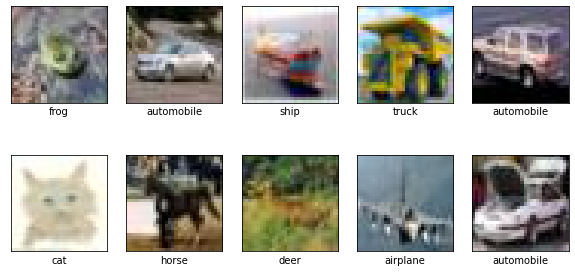

In [39]:
plt.figure(figsize=[10, 5])
for i in range(10):
    import random
    num = random.randint(0, 50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(le.inverse_transform([train_labels[num].item()]).item())
    plt.imshow(train_images[num])
plt.show()

`-` 라벨 빈도수 확인

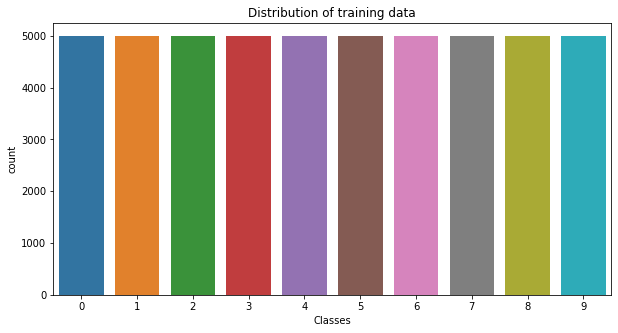

In [40]:
plt.figure(figsize=[10,5])
sns.countplot(np.array(train_labels))
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## Dataset 준비

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

`-` RGB 각각 표준화

In [42]:
RGB_MEAN = [np.mean(train_images[...,i] / 255) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[...,i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

`-` 데이터 변환 방식 정의

In [222]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train=True):
    trans = transforms.Compose([                                                   
        transforms.ToTensor(), ## 0~255 -> 0~1
        transforms.Normalize(RGB_MEAN, RGB_STD) ## 평균을 0, 표준편차를 1로 만듦
    ])
    
    if train:
        trans = transforms.Compose([
            transforms.ToPILImage(), ## numpy array를 PIL이미지로 바꾸고 이미지를 변형시킨다 ## 변형은 PIL이미지 타입일 때 가능
            #transforms.RandomResizedCrop(size=32, scale=(0.6, 1.0)), 
            transforms.RandomHorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            transforms.RandomRotation(degrees=20), ## 무작위로 -20~20도 회전
            transforms.ToTensor(), ## PIL이미지를 다시 텐서로 변환하고 0~1로 정규화
            transforms.Normalize(RGB_MEAN, RGB_STD) ## 평균을 0, 표준편차를 1로 만듦
        ])

    return trans ## 데이터 변환 방식을 반환

`-` 데이터셋 정의

In [44]:
class CustomDataset(Dataset):
    def __init__(self, X: np.array, labels=None, transform=None, target_transform=None):
        self.X = X  ## 넘파이 어레이로 변환된 이미지
        self.labels = labels  ## 라벨
        self.transform = transform  ## X 변환방법
        self.target_transform = target_transform ## 라벨 변환방법
    
    def __getitem__(self, idx):
        numpy_img = self.X[idx]
        if self.transform is not None: 
            transformed_img = self.transform(numpy_img) 
            
        if self.labels is not None:
            label = self.labels[idx]
            if self.target_transform:
                label = self.target_transform(label)             
            return transformed_img, label  ## train   
        
        return transformed_img  ## test
    
    def __len__(self):
        return len(self.X) ## 데이터 개수 반환

In [45]:
transform_train = get_transform() ## train
transform_test = get_transform(train=False) ## test

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=22)
X_test = copy.deepcopy(test_images)

In [47]:
print('X_train 크기:', X_train.shape)
print('X_valid 크기:', X_valid.shape)
print('X_test  크기:', X_test.shape)

X_train 크기: (40000, 32, 32, 3)
X_valid 크기: (10000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


## 모델 설계

In [95]:
#nn.init.xavier_normal_?

In [48]:
w = torch.empty(2, 2)

In [49]:
print(w)

tensor([[-7.0833e-24,  3.0764e-41],
        [ 3.3631e-44,  0.0000e+00]])


In [50]:
nn.init.xavier_normal_(w) ## 모델의 가중치를 가우시안 분포를 사용하여 초기화
print(w)

tensor([[-0.4582, -0.9587],
        [ 1.0913, -1.1260]])


In [78]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = models.resnet18(pretrained=False) ## Resnet18 아키텍쳐사용
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(1000, 10) ## resnet18의 최종 output차원은 1000
        nn.init.xavier_normal_(self.fc.weight) ## 모델의 가중치 초기화
        
    def forward(self, x):
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [79]:
## 랜덤 시드 고정
torch.manual_seed(22)

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [89]:
learning_rate = 0.001
epochs = 15
batch_size = 100

`-` train 데이터셋과 데이터로더

In [81]:
train_dataset = CustomDataset(X=X_train, labels=y_train, transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

`-` valid 데이터셋과 데이터로더

In [176]:
valid_dataset = CustomDataset(X=X_valid, labels=y_valid, transform=transform_train) ## trasform_test는 test 데이터에 적용
## 일반화 능력을 따지는 것이므로 transform_train을 적용시켜야 할 듯
## 예시로 정석대로 작성된 mnist데이터셋을 가지고 휘갈겨 쓴 손글씨(숫자)를 예측하려면
## 가지고 있는 데이터를 변형시켜야 한다
## 그런데 train, valid로 나눴을 때 valid 데이터가 test 데이터를 대표하지 못한다면
## 평가하는 것이 의미가 없다
## 그러므로 valid 데이터에도 transform_train을 적용시켜 test 데이터를 대표하도록 만들어야 한다
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [83]:
total_batch = len(train_dataloader)
print(f'총 배치의 수 : {total_batch}')

총 배치의 수 : 400


In [91]:
## 모델 정의
net = CustomModel().to(device)

In [92]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)   ## 비용 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) ## 옵티마이저에 최적화할 파라미터와 학습률 전달

In [86]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

`-` 이제 모델을 훈련시키자

In [93]:
net.train() ## 훈련모드
for epoch in tqdm(range(epochs)): ## 에폭 1번당 대략 30초 걸림
    avg_loss = 0 ## 평균 loss

    for X, y in train_dataloader: # 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X = X.to(device)
        y = y.to(device) ## shape를 2d에서 1d로 맞춰준다

        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = net(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y) ## 오차를 계산
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트

        avg_loss += (loss / total_batch)

    print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, avg_loss))

  7%|▋         | 1/15 [00:27<06:31, 27.96s/it]

[Epoch:    1] loss = 1.83258295


 13%|█▎        | 2/15 [00:55<06:02, 27.87s/it]

[Epoch:    2] loss = 1.52169394


 20%|██        | 3/15 [01:23<05:33, 27.78s/it]

[Epoch:    3] loss = 1.24198735


 27%|██▋       | 4/15 [01:51<05:04, 27.72s/it]

[Epoch:    4] loss = 1.10114658


 33%|███▎      | 5/15 [02:18<04:37, 27.72s/it]

[Epoch:    5] loss = 1.01584136


 40%|████      | 6/15 [02:46<04:10, 27.79s/it]

[Epoch:    6] loss = 0.953359604


 47%|████▋     | 7/15 [03:14<03:42, 27.80s/it]

[Epoch:    7] loss = 0.891764045


 53%|█████▎    | 8/15 [03:42<03:14, 27.82s/it]

[Epoch:    8] loss = 0.859264076


 60%|██████    | 9/15 [04:10<02:47, 27.88s/it]

[Epoch:    9] loss = 0.828564882


 67%|██████▋   | 10/15 [04:38<02:19, 27.87s/it]

[Epoch:   10] loss = 0.816699803


 73%|███████▎  | 11/15 [05:06<01:51, 27.85s/it]

[Epoch:   11] loss = 0.752397597


 80%|████████  | 12/15 [05:33<01:23, 27.86s/it]

[Epoch:   12] loss = 0.718867064


 87%|████████▋ | 13/15 [06:01<00:55, 27.86s/it]

[Epoch:   13] loss = 0.697906494


 93%|█████████▎| 14/15 [06:29<00:27, 27.82s/it]

[Epoch:   14] loss = 0.690714657


100%|██████████| 15/15 [06:57<00:00, 27.82s/it]

[Epoch:   15] loss = 0.709212363


`-` 이제 훈련된 모델을 평가하자

In [187]:
net.eval() ## 평가모드
valid_loss = [] 
acc_list = []

with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
    for X, y in valid_dataloader: ## 7초 걸림
        X = X.to(device)
        y = y.to(device)
        yhat = net(X)
        loss = loss_fn(yhat,y)
        acc = accuracy(y.detach().cpu().numpy(), yhat.detach().cpu().numpy().argmax(-1))                                                         
        valid_loss.append(loss.cpu().numpy())
        acc_list.append(acc)
            
print(f'Mean Valid Loss : {np.mean(valid_loss):>8f}') ## 평가 루프 종료시 평균 loss를 출력
print(f'Mean Valid accuracy : {np.mean(acc_list):>8f}') ## 평가 루프 종료시 accuracy를 출력

Mean Valid Loss : 0.825987
Mean Valid accuracy : 0.714600


## test 예측

In [205]:
test_dataset = CustomDataset(X=X_test, labels=None, transform=transform_test)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [224]:
preds = None

for test_batch, y in tqdm(test_dataloader): ## 왜 test,batch, y로 받아야할까? 라벨이 없는데...
    test_batch = test_batch.to(device)
    yhat = net(test_batch)
    
    pred = yhat.detach().cpu().numpy().argmax(-1)
    if preds is None:
        preds = pred
    else:
        preds = np.concatenate([preds, pred])

100%|██████████| 400/400 [00:35<00:00, 11.28it/s]


In [233]:
preds.size

40000

`-` 왜 preds 사이즈가 40000이냐??

`-` test 크기는 10000인데...

In [225]:
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CIFAR10/sample_submission.csv')

In [235]:
predictions = le.inverse_transform(preds[:10000])

In [237]:
submission['target'] = predictions

In [239]:
submission.head()

,id,target
0,0000.jpg,frog
1,0001.jpg,cat
2,0002.jpg,truck
3,0003.jpg,airplane
4,0004.jpg,deer


In [238]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/CIFAR10/submission.csv', index=False)